In [ ]:
# prompt: please install all the below using pip

#!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras clean_text pandarallel


In [ ]:
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim
import logging
from gensim.models.doc2vec import TaggedDocument

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.lm import Vocabulary
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, Normalizer
import joblib
from cleantext import clean
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from pandarallel import pandarallel
import ast
import math
from imblearn.under_sampling import RandomUnderSampler
pandarallel.initialize(progress_bar=True)
import time

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import os
IN_COLAB = False
if os.getenv("COLAB_RELEASE_TAG"):
   IN_COLAB = True

news_processed = None
bbc_proccessed = None

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /Users/suneg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/suneg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/suneg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

# Part 1

### Task 1

In [ ]:
#load data
dataPath = "../data/"
if IN_COLAB:
  dataPath = "/content/drive/MyDrive/"
nsdf = pd.read_csv(dataPath + "news_sample.csv")
nsdf = nsdf.reset_index(drop=True)  # Reset index??
nsdf_raw = nsdf.copy(deep=True)
nsdf.info()   # Check column types and missing values



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        250 non-null    int64  
 1   id                250 non-null    int64  
 2   domain            250 non-null    object 
 3   type              238 non-null    object 
 4   url               250 non-null    object 
 5   content           250 non-null    object 
 6   scraped_at        250 non-null    object 
 7   inserted_at       250 non-null    object 
 8   updated_at        250 non-null    object 
 9   title             250 non-null    object 
 10  authors           170 non-null    object 
 11  keywords          0 non-null      float64
 12  meta_keywords     250 non-null    object 
 13  meta_description  54 non-null     object 
 14  tags              27 non-null     object 
 15  summary           0 non-null      float64
dtypes: float64(2), int64(2), object(12)
memory u

In [ ]:
# unique lable values
unique_values = nsdf['type'].unique()
print(unique_values)

['unreliable' 'fake' 'clickbait' 'conspiracy' 'reliable' 'bias' 'hate'
 'junksci' 'political' nan 'unknown']


In [ ]:
#nan and unknown removed as they seem useless when training a classifier
nsdf = nsdf.dropna(subset=['type'])
nsdf = nsdf.loc[nsdf['type']!='unknown']
newunique_values = nsdf['type'].unique()
print(newunique_values)


['unreliable' 'fake' 'clickbait' 'conspiracy' 'reliable' 'bias' 'hate'
 'junksci' 'political']


In [ ]:
# try:
#     nsdf.drop(columns=['Unnamed: 0', 'keywords', 'summary', 'inserted_at', 'updated_at'], inplace=True)
# except:
#     pass
# nsdf.info()

Cleaning and Preprocessing

In [ ]:
def cleanText(data, column):
    data[column] = data[column].parallel_apply(clean_text_help)
    return data

def clean_text_help(text):
    if isinstance(text, str):
        # Remove excess whitespace
        text = re.sub(r"\s+", " ", text).strip()
        #replace dates
        text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])[-/.]?(0[1-9]|1[0-2])[-/.]?([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 1
        text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])\s([A-Za-z]{3})\s([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 2
        return clean(text, lower=True, no_line_breaks=True, no_numbers=True, no_emails=True, no_urls=True, no_punct=True, replace_with_url=r"__URL__", replace_with_email=r"__EMAIL__", replace_with_number=r"__NUM__", replace_with_digit=r"__NUM__")
    raise TypeError("Clean_text passed non-string")

In [ ]:
#Tokenize the text function
def tokenizeText(data, column):
    def tokenize_text_help(text):
        if isinstance(text, str):
            return (word_tokenize(text))
        return text  # Return unchanged if not a string
    data[column] = data[column].parallel_apply(tokenize_text_help)  # Apply function
    return data



In [ ]:
#function for removeing stopwords
def remove_stopwords_help(text):
    text = pd.Series(text)
    stop_words = set(stopwords.words('english'))  # Load stopwords
    return text[~text.isin(stop_words)].to_list()  # Remove stopwords

def remove_stopwords(data, column):
    data['content'] = data['content'].parallel_apply(remove_stopwords_help)  # Apply function
    return data

In [ ]:
#Returns a pandas series, with word and frequency, very fast.
def getFreq(data, column):
    return len(data[column].str.split().explode().value_counts())

def getFreq_tokinized(data, column):
    return len(data[column].explode().value_counts())

def Vocab_size_tokinized(data, column):
    return len(data[column].explode())

def Vocab_size(data, column):
    return len(data[column].str.split().explode())

In [ ]:

#function for removeing stopwords
def dataStemming(data, column):
    ps = PorterStemmer()
    def dataStemming_help(text):
        text = pd.Series(text)
        if(isinstance(text, str)):
            return pd.Series(ps.stem(text))
        return text.apply(ps.stem).to_list()
    data[column] = data[column].parallel_apply(dataStemming_help)  # Apply function
    return data


In [ ]:
printing_copy = nsdf_raw.copy(deep=True)
freq_raw = getFreq(printing_copy, 'content')
data_size_raw = Vocab_size(printing_copy, 'content')

printing_copy = printing_copy.dropna(subset=['type'])
printing_copy = printing_copy.loc[nsdf['type']!='unknown']

freq_pre = getFreq(printing_copy, 'content')
data_size_pre = Vocab_size(printing_copy, 'content')
freq_clean = getFreq(cleanText(printing_copy, 'content'), 'content')
data_size_clean = Vocab_size(printing_copy, 'content')
freq_token = getFreq_tokinized(tokenizeText(printing_copy, 'content'), 'content')
data_size_token = Vocab_size_tokinized(printing_copy, 'content')
freq_stopwords = getFreq_tokinized(remove_stopwords(printing_copy, 'content'), 'content')
data_size_stopwords = Vocab_size_tokinized(printing_copy, 'content')
freq_stemmed = getFreq_tokinized(dataStemming(printing_copy, 'content'), 'content')
data_size_stemmed = Vocab_size_tokinized(printing_copy, 'content')


print("--- Unique words ---")
print("Raw: ", freq_raw)
print("Preprocessing: ", freq_pre)
print("After cleaning: ", freq_clean)
print("After tokenizing: ", freq_token)
print("After removing stopwords: ", freq_stopwords)
print("After stemming: ", freq_stemmed)

print(" ")

print("--- Word counts ---")
print("Raw: ", data_size_raw)
print("Preprosseing: ", data_size_pre)
print("After cleaning: ", data_size_clean)
print("After tokenizing: ", data_size_token)
print("After removing stopwords: ", data_size_stopwords)
print("After stemming: ", data_size_stemmed)


#Delete copy:
del printing_copy
del freq_pre, data_size_pre, freq_clean, data_size_clean, freq_token, data_size_token, freq_stopwords, data_size_stopwords, freq_stemmed, data_size_stemmed



--- Unique words ---
Raw:  30005
Preprocessing:  27721
After cleaning:  15649
After tokenizing:  15641
After removing stopwords:  15509
After stemming:  10486
 
--- Word counts ---
Raw:  170462
Preprosseing:  151344
After cleaning:  150431
After tokenizing:  150679
After removing stopwords:  86067
After stemming:  86067


In [ ]:
# One big function to process data:
def processData(data, column):
    def apply_sequential_helper(functions):
        # assume type siganture of functions to be List[f : String -> string ]
        def inner(text):
            for f in functions:
                text = f(text)
            return text
        return inner

    def clean_text_help(text):
        if isinstance(text, str):
            # Remove excess whitespace
            text = re.sub(r"\s+", " ", text).strip()
            #replace dates
            text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])[-/.]?(0[1-9]|1[0-2])[-/.]?([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 1
            text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])\s([A-Za-z]{3})\s([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 2
            return clean(text, lower=True, no_line_breaks=True, no_numbers=True, no_emails=True, no_urls=True, no_punct=True, replace_with_url=r"__URL__", replace_with_email=r"__EMAIL__", replace_with_number=r"__NUM__", replace_with_digit=r"__NUM__")
        raise TypeError("Clean_text passed non-string")

    def tokenize_text_help(text):
        if isinstance(text, str):
            return pd.Series(word_tokenize(text))
        return text  # Return unchanged if not a string

    def remove_stopwords_help(text):
      # text is a Series[str]
        stop_words = set(stopwords.words('english'))  # Load stopwords
        #if isinstance(text, str):
        #    return [word for word in text.at[0, 'content'] if not word.lower() in stop_words]
        #return text  # Return unchanged if not a string
        return text[~text.isin(stop_words)]

    ps = PorterStemmer()
    def dataStemming_help(text):
        #if isinstance(text, str):
        #    return ps.stem(text)
        #return text  # Return unchanged if not a string
        if(isinstance(text, str)):
            return pd.Series(ps.stem(text))
        return text.apply(ps.stem)

    def type_cleaner(text):
        if isinstance(text, str):
            return pd.Series(text).to_list()
        return text.to_list()

    data[column] = data[column].parallel_apply(apply_sequential_helper(
        [clean_text_help, # str -> str
        tokenize_text_help, # str -> list[str]
        remove_stopwords_help, #series[str] -> series[str]
        dataStemming_help, #series[str] -> series[str]
        type_cleaner # series[str] -> series[str]
    ]))
    return data

In [ ]:
"""
nsdf_cleaned = cleanText(nsdf, 'content')
nsdf_tokenized = tokenizeText(nsdf_cleaned, 'content')                  #tokenizing
nsdf_cleaned_tokenized_nostopwords = remove_stopwords(nsdf_tokenized, 'content')           #removing stopwords
nsdf_preprocessed = dataStemming(nsdf_cleaned_tokenized_nostopwords, 'content')
"""
nsdf_processed = processData(nsdf, 'content')
nsdf_processed.dropna(subset=['content'], inplace=True)  # Drop rows with no content
nsdf_processed.reset_index(drop=True, inplace=True)  # Reset index
print(nsdf_processed.at[0, 'content'])

TypeError: Clean_text passed non-string

In [ ]:
#word frequency pre preprocessing
# print("word frequency pre preprocessing")
# word_frequency_pre = getFreq(nsdf_raw, 'content').sum()
# print(word_frequency_pre)

In [ ]:
#word frequency post preprocessing
# print("word frequency post preprocessing")
# getfreq assumes different type signature, so we have to do it this way
# word_frequency_post = nsdf_processed["content"].explode().value_counts().sum()
# print(word_frequency_post)

In [ ]:
#word frequency post stemming
#print("word frequency post stemming")
#word_frequency_postStem = getFrequency(nsdf_.processed, 'content', 1)
#print(sum(word_frequency_postStem.values()))

In [ ]:
#pre = word_frequency_pre
#post = word_frequency_post
#print("Reduction rate of the vocabulary size after removing stopwords:")
#print(abs(pre -post))
#print("Further  reduction rate of the vocabulary size after stemming")
#postStem = sum(word_frequency_post.values())
#print(abs(post -postStem))

### Task 2

In [ ]:
#load data
fakeNewsCorpus = pd.read_csv(dataPath + "995,000_rows.csv")
#Hva saten er den der unnamed???
print(fakeNewsCorpus.head())
#fakeNewsCorpus['content'].duplicated()
news_noDup = fakeNewsCorpus.drop_duplicates(subset=['content']).dropna(subset=['content']).reset_index(drop=True)

In [ ]:
#Cleaning
news_processed = processData(news_noDup, 'content')
news_processed.to_json(dataPath + "news_processed.json", orient='records', lines=True)

### Task 3

In [ ]:
if news_processed is None:
    json_reader = pd.read_json(dataPath + "news_processed.json", orient='records', lines=True, chunksize=1500)
    news_processed = pd.concat(json_reader, ignore_index=True)
# timed: 12 min på M1 macbook chunk=1000
print(news_processed.info())   # Check column types and missing values
#fndf = fakeNewsCorpus.reset_index(drop=True)  # Reset index
fndf = news_processed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812912 entries, 0 to 812911
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        812911 non-null  float64       
 1   id                812912 non-null  object        
 2   domain            812912 non-null  object        
 3   type              770599 non-null  object        
 4   url               812912 non-null  object        
 5   content           812912 non-null  object        
 6   scraped_at        812911 non-null  object        
 7   inserted_at       812911 non-null  datetime64[ns]
 8   updated_at        812911 non-null  datetime64[ns]
 9   title             812735 non-null  object        
 10  authors           502785 non-null  object        
 11  keywords          0 non-null       float64       
 12  meta_keywords     775004 non-null  object        
 13  meta_description  421991 non-null  object        
 14  tags

### Cleaning and Preprocessing

In [ ]:
print("Pandas DataFrame:")
display(fndf.iloc[0])



## Observations about dataset

In [ ]:
unique_values = fndf['type'].unique()
print(unique_values)
#hard to know how to classify nan and unknown, so removed for now
# we also remove the a weird type 
fndf = fndf.dropna(subset=['type'])
fndf = fndf.loc[(fndf['type']!='unknown') & (fndf['type']!='unreliable') & (fndf['type'] != '2018-02-10 13:43:39.521661')]
# Need to reset index

newunique_values = fndf['type'].unique()
print(newunique_values)


['political' 'fake' 'satire' 'reliable' 'conspiracy' 'unreliable' 'bias'
 'rumor' 'unknown' None 'clickbait' 'hate' 'junksci'
 '2018-02-10 13:43:39.521661']
['political' 'fake' 'satire' 'reliable' 'conspiracy' 'bias' 'rumor'
 'clickbait' 'hate' 'junksci']


In [ ]:
# requires running all_dist loading out fo order, since we need word distributions

from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

vocab = fndf["content"].explode().value_counts().index[:10000]

#vocab = {val for (val, _) in all_dist.most_common(10000)}
tfidf_all_model = TfidfVectorizer(analyzer=lambda x: x, vocabulary=vocab)
tfidf_vec = tfidf_all_model.fit_transform(fndf["content"])

PCA_model = PCA(n_components=2)
PCA_data = PCA_model.fit_transform(tfidf_vec)
PCA_df = pd.DataFrame(PCA_data, columns=["PCA1", "PCA2"])
PCA_df["type"] = fndf["type"]

sns.kdeplot(data=PCA_df, x="PCA1", y="PCA2", hue="type", fill=False, alpha=0.5)
#sns.kdeplot(x=PCA_real[:, 0], y=PCA_real[:, 1],color="blue", thresh=0.15)
#sns.kdeplot(x=PCA_fake[:, 0], y=PCA_fake[:, 1],color="red", thresh=0.15, alpha=0.7)


: 

: 

<Axes: xlabel='PCA1', ylabel='PCA2'>

/Users/suneg/miniconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/suneg/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


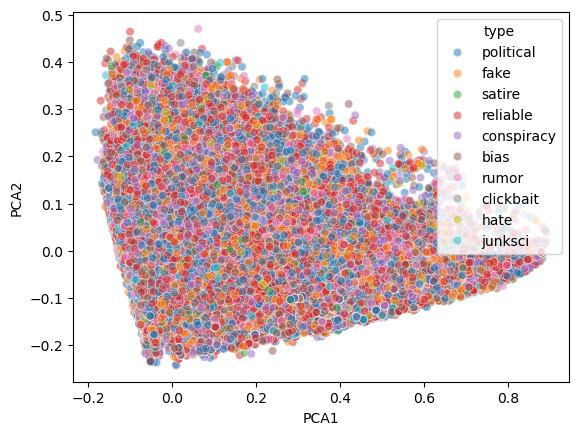

In [ ]:
sns.scatterplot(data=PCA_df, x="PCA1", y="PCA2", hue="type", alpha=0.5)

In [ ]:

# groups (reliable) as truenews 1 and (all others) in fakenews 0
    #note this is naive and should be reconsidered later

# reliable, clickbait and political are all, by their contents, factually correct (albeit possibly politcally motivated)
# we deem those to be "real" news
print("adding binary labels")
fndf['type'] = fndf['type'].replace(r'^(reliable|clickbait|political)$', '1', regex=True) 
fndf['type'] = fndf['type'].replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'
#maybe fix this? what remains?
fndf['type'] = fndf['type'].fillna('0')

newunique_values = fndf['type'].unique()
print(newunique_values)
fndf.shape[0]
fndf['type'] = fndf['type'].astype(int)  # Convert to integer

print(("real vs fake:"))
print(fndf['type'].value_counts())

adding binary labels
['1' '0']
real vs fake:
type
1    378763
0    344969
Name: count, dtype: int64


In [ ]:

print(relib_news.shape[0], " : ", fake_news.shape[0])

print("distribution for real news")
#print(relib_news["content"].explode().value_counts())
real_dist = FreqDist(relib_news["content"].explode())
print(real_dist.most_common(200))

print("distribution for fake news")
#print(fake_news["content"].explode().value_counts())
fake_dist = FreqDist(fake_news["content"].explode())
print(fake_dist.most_common(200))

print("distribution for all news")
#print(fndf["content"].explode().value_counts())
all_dist = FreqDist(fndf["content"].explode())
print(all_dist.most_common(200))
joblib.dump((real_dist, fake_dist, all_dist), dataPath + "dists.pkl")

In [ ]:

(real_dist, fake_dist, all_dist) = joblib.load(dataPath + "dists.pkl")

        Unnamed: 0       id              domain  type  \
0            732.0  7444726  nationalreview.com     1   
3           1518.0  9560791         nytimes.com     1   
5           3732.0  8018634      online.wsj.com     1   
6           7968.0  3527674        dailykos.com     1   
7           2968.0  2015968        dailykos.com     1   
...            ...      ...                 ...   ...   
812899      7978.0  9377040         nytimes.com     1   
812901      4912.0  3244085        dailykos.com     1   
812904      2427.0  8481486         nytimes.com     1   
812906      7584.0  8546643         nytimes.com     1   
812907      7167.0  9326229         nytimes.com     1   

                                                      url  \
0       http://www.nationalreview.com/node/152734/%E2%...   
3       https://query.nytimes.com/gst/fullpage.html?re...   
5       http://online.wsj.com/articles/shift-options-1...   
6       https://www.dailykos.com/stories/2014/05/02/12...   
7       ht

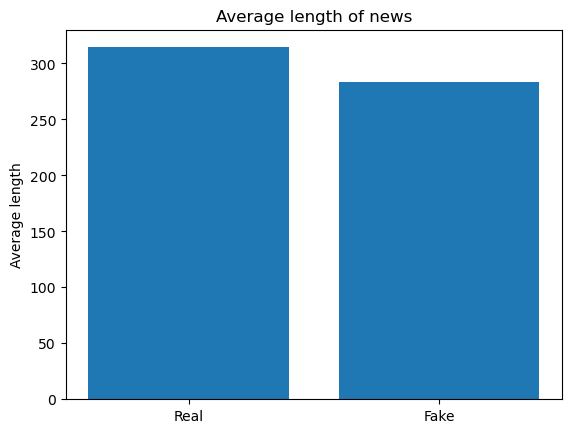

In [ ]:
avg_len_real = relib_news["content"].apply(len).mean()
print(relib_news)
avg_len_fake = fake_news["content"].apply(len).mean()
print("Average length of real news: ", avg_len_real)
print("Average length of fake news: ", avg_len_fake)
plt.bar(["Real", "Fake"], [avg_len_real, avg_len_fake])
plt.title("Average length of news")
plt.ylabel("Average length")
plt.show()

In [ ]:
# add one discounting
fake_total = int(pd.Series([b+1 for (a, b) in fake_dist.most_common(10000)]).sum())
real_total = int(pd.Series([b+1 for (a, b) in real_dist.most_common(10000)]).sum())
all_total = int(pd.Series([b+1 for (a, b) in all_dist.most_common(10000)]).sum())
print(f"real total: {real_total}, fake total: {fake_total}")
print(real_total-fake_total)


real total: 109315624, fake total: 85853406
23462218


In [ ]:

real_pd_prob = pd.Series(dict(real_dist)).apply(lambda x: x/real_total)
fake_pd_prob = pd.Series(dict(fake_dist)).apply(lambda x: x/fake_total)



In [ ]:
def entropy_calculation(row):
    word = row["word"]
    # use one cause of add one discounting
    row["real_prob"] = real_dist.get(word, 1) / all_dist.get(word, 1/all_total)
    #row["real_prob"] = real_prob
    row["fake_prob"] = fake_dist.get(word, 1) / all_dist.get(word, 1/all_total)
    #row["fake_prob"] = fake_prob
    #row["fake_prob"] = -1*fake_prob*np.log2(fake_prob)
    #row["real_entropy"] = -1*real_prob*np.log2(real_prob)
    #row["entropy"] = row["fake_entropy"] + row["real_entropy"]
    row["prob_diff"] = abs(row["real_prob"] - row["fake_prob"])
    return row
    

In [ ]:
word_entropy = pd.DataFrame(all_dist.most_common(1000), columns=["word", "count"]).apply(entropy_calculation, axis=1)
word_entropy = word_entropy.sort_values("fake_prob", ascending=False)
print(word_entropy.head(20))

          word   count  real_prob  fake_prob  prob_diff
889      getti   51272   0.065026   0.934974   0.869949
720       cent   62940   0.171830   0.828170   0.656339
755       gold   60003   0.230005   0.769995   0.539990
878         uk   51675   0.236110   0.763890   0.527779
190      sourc  158033   0.256035   0.743965   0.487930
943     syrian   48433   0.257634   0.742366   0.484731
683     reader   65597   0.261917   0.738083   0.476165
290     russia  125465   0.273295   0.726705   0.453409
809      earth   55830   0.276518   0.723482   0.446964
916         un   49879   0.276690   0.723310   0.446621
299         de  121753   0.276700   0.723300   0.446601
572      syria   75366   0.277751   0.722249   0.444498
103        url  209053   0.284363   0.715637   0.431273
349    russian  108299   0.293761   0.706239   0.412478
477         la   85678   0.294638   0.705362   0.410724
523        add   79471   0.316442   0.683558   0.367115
517          |   79919   0.331285   0.668715   0

<Axes: xlabel='word'>

<Figure size 1400x900 with 0 Axes>

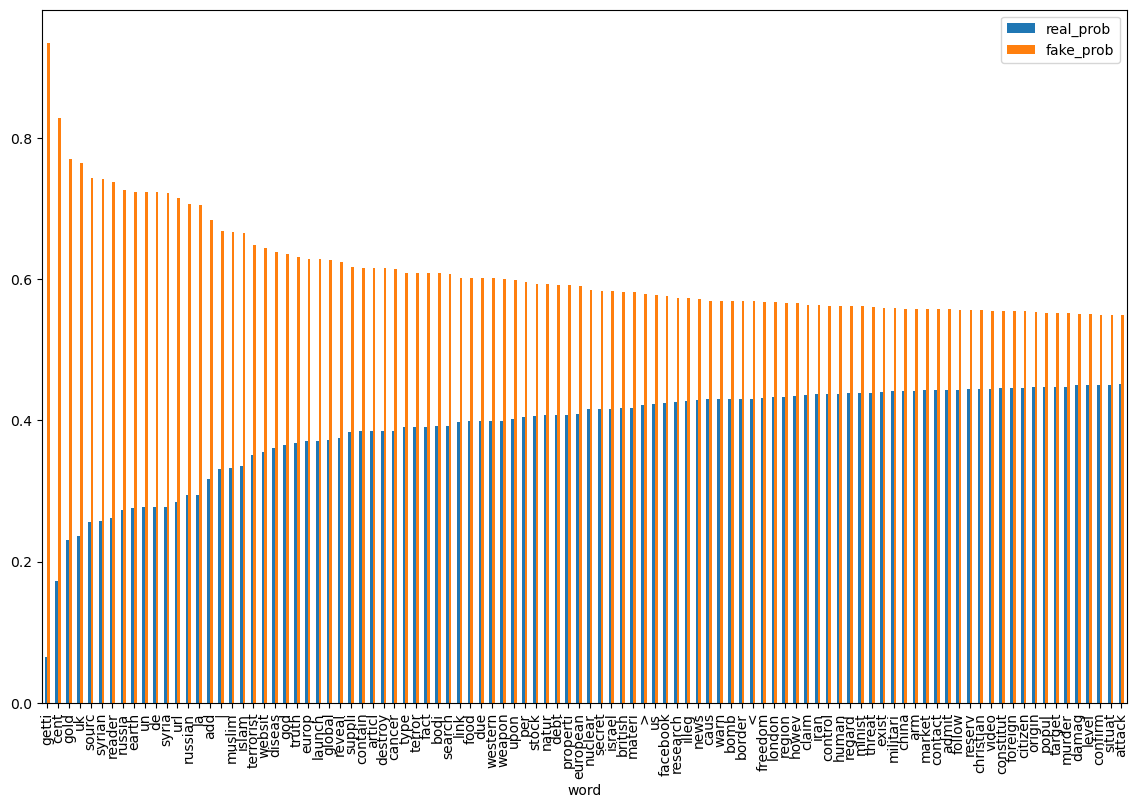

In [ ]:
plt.figure(figsize=(14, 9))

word_entropy_lim = word_entropy.head(100)
width = 0.2
# Bar chart with stacking
#plt.bar(word_entropy_lim["word"], word_entropy_lim["real_prob"] + word_entropy_lim["fake_prob"], label="Real", color="blue")
#plt.bar(word_entropy_lim["word"], word_entropy_lim["fake_prob"], label="Fake", color="red")
"""
plt.bar(word_entropy_lim["word"])

# Labels and title
plt.xlabel("Words")
plt.ylabel("Entropy")
plt.title("Stacked Bar Chart of Real vs. Fake Entropy per Word")
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Show plot
plt.show()
"""

word_entropy_lim[["word", "real_prob", "fake_prob"]].plot(kind='bar', x='word', stacked=False, figsize=(14, 9))

In [ ]:
# tf idf
from sklearn.feature_extraction.text import TfidfVectorizer

vocab = {val for (val, _) in all_dist.most_common(10000)}
print(vocab)
tfidf_real_vec = TfidfVectorizer(analyzer=lambda x: x, vocabulary=vocab)
tfidf_fake_vec = TfidfVectorizer(analyzer=lambda x: x, vocabulary=vocab)
tfidf_real = tfidf_real_vec.fit_transform(relib_news["content"])
tfidf_fake = tfidf_fake_vec.fit_transform(fake_news["content"])



{'jenni', 'mock', 'blockbust', 'convoy', 'distrust', 'disallow', 'slate', 'grown', 'pablo', 'myer', 'outlet', 'momentum', 'alumni', 'epidem', 'honesti', 'hid', 'novak', 'relentlessli', 'layer', 'triangl', 'backyard', 'iron', 'weiner', 'salut', 'frontpag', 'ton', 'persist', 'superfici', 'quarterfin', 'domino', 'frack', 'theatric', 'taxexempt', 'casey', 'acut', 'break', 'mojo', 'thu', '29th', 'warrior', 'freshman', 'philadelphia', 'howev', 'ml', 'insur', 'granddaught', 'bonu', 'sneak', 'current', 'collid', 'mugab', 'cheat', 'williamsburg', 'lesser', 'medit', 'selfproclaim', 'resign', 'reagan', 'colbert', 'dub', 'tourism', 'stigma', 'coalit', 'prolong', 'amnesti', 'powerless', 'thread', 'kentucki', 'cant', 'filthi', 'adapt', 'grace', 'sink', 'dissolv', 'menu', 'brandon', 'documentari', 'polish', 'raymond', 'boss', 'discriminatori', 'specialist', 'dreamer', 'nova', 'disgrac', 'starvat', 'luck', 'debbi', 'unconsci', 'exit', 'heavenli', 'antiwar', 'real', 'psychic', '30', 'lesson', 'compromi

PicklingError: Can't pickle <function <lambda> at 0x690f6f740>: it's not found as __main__.<lambda>

In [ ]:
tfidf_all_model = TfidfVectorizer(analyzer=lambda x: x, vocabulary=vocab)
tfidf_all_model.fit(fndf["content"])
tfidf_all_real = tfidf_all_model.transform(relib_news["content"])
tfidf_all_fake = tfidf_all_model.transform(fake_news["content"])

In [ ]:

joblib.dump((tfidf_real, tfidf_fake, tfidf_all_real, tfidf_all_fake), dataPath + "tfidf.pkl")

['../data/tfidf.pkl']

(378763, 2)


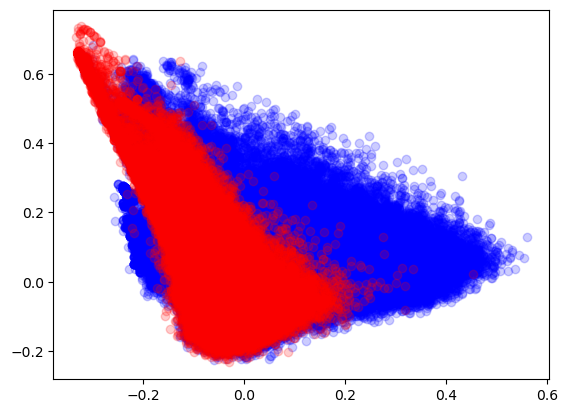

In [ ]:

PCA_obj = PCA(n_components=2)
PCA_obj.fit(tfidf_all_real)

PCA_real = PCA_obj.transform(tfidf_all_real)
PCA_fake = PCA_obj.transform(tfidf_all_fake)

print(PCA_real.shape)

plt.scatter(PCA_real[:, 0], PCA_real[:, 1], color="blue", label="Real", alpha=0.2)
plt.scatter(PCA_fake[:, 0], PCA_fake[:, 1], color="red", label="Fake", alpha=0.2)


<Axes: >

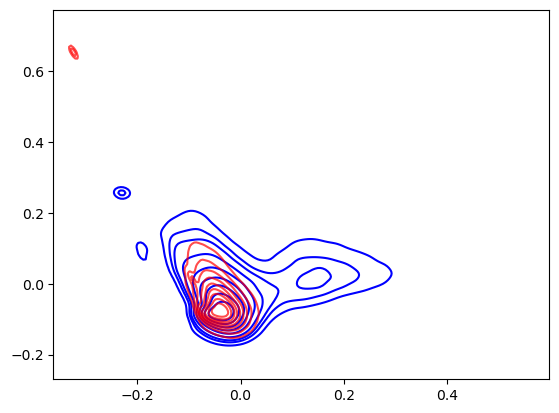

In [ ]:
sns.kdeplot(x=PCA_real[:, 0], y=PCA_real[:, 1],color="blue", thresh=0.15)
sns.kdeplot(x=PCA_fake[:, 0], y=PCA_fake[:, 1],color="red", thresh=0.15, alpha=0.7)

# observationer
- det virker ikke til at de er seperatble kun udfra bag in a word med tf-idf
- der er nogle regions hvor vi kan, og andre hvor vi ikke umiddelbart kan
- måske er f.eks. embeddings bedre?

In [ ]:
# tjek som ovenfor men med alle labels?


    Unnamed: 0       id                 domain  type  \
0        732.0  7444726     nationalreview.com     1   
1       1348.0  6213642      beforeitsnews.com     0   
2       7119.0  3867639       dailycurrant.com     0   
3       1518.0  9560791            nytimes.com     1   
4       9345.0  2059625    infiniteunknown.net     0   
..         ...      ...                    ...   ...   
95      4405.0  9523600            nytimes.com     1   
96      8642.0  3780677      beforeitsnews.com     0   
97       102.0      122  blackagendareport.com     0   
98      7550.0  6508433        www.newsmax.com     0   
99      3648.0  1357230       www.ammoland.com     0   

                                                  url  \
0   http://www.nationalreview.com/node/152734/%E2%...   
1   http://beforeitsnews.com/economy/2012/06/the-c...   
2   http://dailycurrant.com/2016/01/18/man-awoken-...   
3   https://query.nytimes.com/gst/fullpage.html?re...   
4   http://www.infiniteunknown.net/2011/09

Amount of words only present in one set than another: 272
[('said', np.float64(0.005989224878196336)), ('mr', np.float64(0.005948864596458583)), ('new', np.float64(0.0032736189032688033)), ('york', np.float64(0.003178806966138607)), ('main', np.float64(0.0027339084417915206)), ('pleas', np.float64(0.002594530014039337)), ('num', np.float64(0.002545392679506993)), ('stori', np.float64(0.002309711351794673)), ('continu', np.float64(0.0022946960553700494)), ('read', np.float64(0.0019017039205412203)), ('sign', np.float64(0.0017832534108624964)), ('advertis', np.float64(0.0016084235979338772)), ('republican', np.float64(0.0014991912922879464)), ('$', np.float64(0.001366216283543495)), ('democrat', np.float64(0.0012577113177079289)), ('offer', np.float64(0.001134012665539164)), ('servic', np.float64(0.0010641342366766002)), ('tri', np.float64(0.0010386466674621067)), ('later', np.float64(0.0010175592504107734)), ('percent', np.float64(0.0010033423376317222)), ('receiv', np.float64(0.0010026

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10857f350>>
Traceback (most recent call last):
  File "/Users/suneg/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


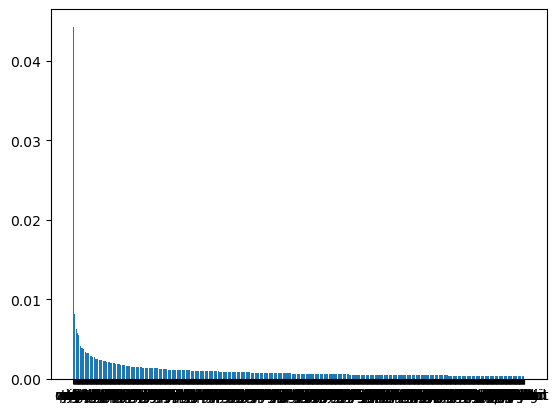

In [ ]:

real_set = set(real_pd.index)
fake_set = set(fake_pd.index)
unique_words = real_set.union(fake_set) - real_set.intersection(fake_set)
print(f"Amount of words only present in one set than another: {len(unique_words)}")

large_diff = [(word, real_pd.get(word, 0) - fake_pd.get(word, 0)) for word in fake_pd.index if abs(real_pd.get(word, 0) - fake_pd.get(word, 0)) > 0.00001]

large_diff.sort(key=lambda x: abs(x[1]), reverse=True)
print(large_diff)

print("Unique tokens:")
for token in ["url", "email", "num", "date"]:
    print(f"TOKEN: {token} - Real: {real_pd[token]}, Fake: {fake_pd[token]}")

plt.bar(real_pd.keys(), real_pd.values)
plt.show()

## Task 4

In [ ]:
# Splitting into test, train and validation
X_train_full, X_valtest_full, y_train, y_valtest = train_test_split(fndf, fndf['type'], test_size=0.2, random_state=42) # Replace with fakenews dataset for real linreg.
X_test_full, X_val_full, y_test, y_val = train_test_split(X_valtest_full, y_valtest, test_size=0.5, random_state=42)
# x_train = testing_ x, y_train = training_y
# (x_test
X_train = X_train_full['content']
X_test = X_test_full['content']
print("train size:", y_train.shape)
print("val size:", y_val.shape)
print("test size:", y_test.shape)


train size: (578985,)
val size: (72374,)
test size: (72373,)


# Part 2

## Task 0, splitting labels into reliable and unreliable.

In [ ]:

unique_values = fndf['type'].unique()
print(unique_values)
#hard to know how to classify nan and unknown, so removed for now
# we also remove the a weird type 
fndf = fndf.dropna(subset=['type'])
fndf = fndf.loc[fndf['type']!='unknown']
# Need to reset index

newunique_values = fndf['type'].unique()
print(newunique_values)


# groups (reliable) as truenews 1 and (all others) in fakenews 0
    #note this is naive and should be reconsidered later

# reliable, clickbait and political are all, by their contents, factually correct (albeit possibly politcally motivated)
# we deem those to be "real" news
fndf['type'] = fndf['type'].replace(r'^(reliable|clickbait|political)$', '1', regex=True) 
fndf['type'] = fndf['type'].replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'
#fndf['type'] = fndf['type'].fillna('0')

newunique_values = fndf['type'].unique()
print(newunique_values)
fndf.shape[0]

## Task 1 - Simple linear regression model.

Get the top 10000 words, and how often they occur in each article

In [ ]:
#Standarize fndf?

# get top 10000 words for vocab in training data to avoid leaking data from test set
print("Finding vocabulary:")
vocab = X_train.explode().value_counts()[:10000].keys()
#training_split_freq = FreqDist(X_train.explode())
#vocab = [x for (x, y) in training_split_freq.most_common(10000)]
#print(pd.Series(nsdf["content"][0]).value_counts())
#print(pd.Series(fndf["content"][0]).value_counts()[top.keys()[0]])

def CountFreq(words, vocab):
    # words: Series[str]
    # vocab: list[str] of words to count
    words = pd.Series(words)
    new_row = pd.Series(np.zeros(len(vocab)))
    n = len(vocab)
    words_in_article = pd.Series(words).value_counts()
    return vocab.apply(lambda x: words_in_article.get(x, 0))

#rowsFreq = X_train.parallel_apply(lambda row: CountFreq(row, pd.Series(top.keys())))
# her bruger vi forskellige vocabularies - vi skal finde vocab for træning og apply den til test_rowsFreq
vectorizer = CountVectorizer(analyzer=lambda x: x, vocabulary=vocab)
print("vectorizing X_train")
rowsFreq = vectorizer.fit_transform(X_train)
print("vectorizing X_test")
test_rowsFreq = vectorizer.fit_transform(X_test)
print(rowsFreq)


In [ ]:
#store data

joblib.dump((rowsFreq, test_rowsFreq), dataPath + "rowsFreq.pkl")
joblib.dump((y_train, y_test, y_val), dataPath + "y.pkl")
#joblib.dump((x_undersampled, y_undersampled), dataPath + "undersampled.pkl")
#joblib.dump((X_train_full, X_test_full, X_val_full), dataPath + "X_full.pkl")

Creating the linear regression

In [ ]:
#scaler = StandardScaler(with_mean=False)
scaler = Normalizer()
undersampler = RandomUnderSampler(random_state=42)

X_train_scale = scaler.fit_transform(rowsFreq)
X_test_scale = scaler.transform(test_rowsFreq)
x_undersampled, y_undersampled = undersampler.fit_resample(X_train_scale, y_train)
print("Starting model training:")
linReg = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)#, class_weight="balanced")
linReg_weighed = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42, class_weight="balanced")
linReg_undersampled = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)
print("fitting standard model")
linReg.fit(X_train_scale, y_train)
print("fitting weighted model")
linReg_weighed.fit(X_train_scale, y_train)
print("fitting undersampled model")
linReg_undersampled.fit(x_undersampled, y_undersampled)

y_pred = linReg.predict(X_test_scale)
y_pred_weighted = linReg_weighed.predict(X_test_scale)
y_pred_undersampled = linReg_undersampled.predict(X_test_scale)
f1 = f1_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred_weighted)
f1_undersampled = f1_score(y_test, y_pred_undersampled)
# Print results
print("Standard : Weighted : Undersampled")
print(f"F1 Score: {f1:.4f} : {f1_weighted:.4f} : {f1_undersampled:.4f}")
print(f"Hyperparameters: max_iter=1000, solver='liblinear', binary bag-of-words")


In [ ]:
# Save model
joblib.dump((linReg, linReg_weighed, linReg_undersampled), dataPath + "linReg.pkl")

In [ ]:
# Reload data 
(linReg, linReg_weighed, linReg_undersampled) = joblib.load(dataPath + "linReg.pkl")
(rowsFreq, test_rowsFreq) = joblib.load(dataPath + "rowsFreq.pkl")
(y_train, y_test, y_val) = joblib.load(dataPath + "y.pkl")
#(x_undersampled, y_undersampled) = joblib.load(dataPath + "undersampled.pkl")

scaler = Normalizer()
X_train_scale = scaler.fit_transform(rowsFreq)
X_test_scale = scaler.transform(test_rowsFreq)

y_pred = linReg.predict(X_test_scale)
y_train_pred = linReg.predict(X_train_scale)

In [ ]:
#Visualize
print(f"F1 Score: Train: {f1_score(y_train, y_train_pred):.4f}, Test: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy (test): {accuracy_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linReg.classes_)
disp.plot()
plt.show()

### Task 3

In [ ]:
bbc_raw = pd.from_csv(dataPath + "bbc_articles.csv")

bbc_processed = processData(bbc_raw, 'text')
bbc_processed['type'] = 1

bbc_processed.to_json(dataPath + "bbc_processed.json", orient='records', lines=True)


In [ ]:
if bbc_proccessed is None:
    json_reader = pd.read_json(dataPath + "bbc_processed.json", orient='records', lines=True, chunksize=1500)
    bbc_processed = pd.concat(json_reader, ignore_index=True)

bbcdf = bbc_processed

BBC_train = pd.concat([X_train, bbcdf['text']]).reset_index(drop=True)
BBC_train = scaler.fit_transform(BBC_train)
BBC_y = pd.concat([y_train, bbcdf["type"]])
bbcReg = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)
bbcReg.fit(BBC_train, BBC_y)
BBC_pred = bbcReg.predict(X_test)
print(f"F1: {f1_score(y_test, BBC_pred)}")

# advanced model

In [ ]:
print(X_train.to_frame().reset_index(drop=False))

         index                                            content
0       433076  [articl, friday, challeng, make, market, beave...
1       285997  [justic, eric, garner, street, protest, prosec...
2       182142  [van, gundi, state, long, ago, two, three, poi...
3       319275  [sedco, jone, recogn, manufactur, day, reader,...
4       691056  [san, francisco, gov, arnold, schwarzenegg, po...
...        ...                                                ...
650324  259178  [purdu, univers, purdu, pete, circa, num, poss...
650325  365838  [new, rnc, tv, ad, ok, reader, think, stori, f...
650326  131932  [recent, turkish, polit, circl, talk, white, t...
650327  671155  [mani, news, outlet, report, earlier, today, h...
650328  121958  [sport, time, column, last, sunday, new, men, ...

[650329 rows x 2 columns]


In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# create document embeddings
#tagged_docs = [gensim.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(X_train)]
print("tagging documents")
# brug reset index måske?
#tagged_docs = list(map(gensim.models.doc2vec.TaggedDocument, X_train, X_train.index))
tagged_docs = [TaggedDocument(words=doc, tags=[i]) for doc, i in zip(X_train.values, range(X_train.shape[0]))]


tagging documents


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103356de0>>
Traceback (most recent call last):
  File "/Users/suneg/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103356de0>>
Traceback (most recent call last):
  File "/Users/suneg/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 


In [ ]:
vector_size = 100
embed_model = gensim.models.doc2vec.Doc2Vec(tagged_docs, vector_size=vector_size, min_count=2, workers=4)

2025-03-19 21:39:24,530 : INFO : collecting all words and their counts
2025-03-19 21:39:24,562 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2025-03-19 21:39:39,502 : INFO : PROGRESS: at example #10000, processed 2902402 words (195332 words/s), 93268 word types, 0 tags
2025-03-19 21:39:58,248 : INFO : PROGRESS: at example #20000, processed 5848335 words (157862 words/s), 142797 word types, 0 tags
2025-03-19 21:40:13,940 : INFO : PROGRESS: at example #30000, processed 8813792 words (190262 words/s), 184374 word types, 0 tags
2025-03-19 21:40:29,811 : INFO : PROGRESS: at example #40000, processed 11723299 words (184120 words/s), 222124 word types, 0 tags
2025-03-19 21:40:46,014 : INFO : PROGRESS: at example #50000, processed 14675941 words (182797 words/s), 258851 word types, 0 tags
2025-03-19 21:40:59,540 : INFO : PROGRESS: at example #60000, processed 17569125 words (213923 words/s), 290805 word types, 0 tags
2025-03-19 21:41:07,365 : INFO : PROG

In [ ]:
embed_model.save(dataPath + "doc2vec.model")

2025-03-19 23:39:57,536 : INFO : Doc2Vec lifecycle event {'fname_or_handle': '../data/doc2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-19T23:39:57.536338', 'gensim': '4.3.3', 'python': '3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 10:37:40) [Clang 14.0.6 ]', 'platform': 'macOS-15.3.1-arm64-arm-64bit', 'event': 'saving'}
2025-03-19 23:39:57,560 : INFO : storing np array 'vectors' to ../data/doc2vec.model.dv.vectors.npy
2025-03-19 23:40:00,940 : INFO : storing np array 'vectors' to ../data/doc2vec.model.wv.vectors.npy
2025-03-19 23:40:02,301 : INFO : storing np array 'syn1neg' to ../data/doc2vec.model.syn1neg.npy
2025-03-19 23:40:02,711 : INFO : not storing attribute cum_table
2025-03-19 23:40:09,518 : INFO : saved ../data/doc2vec.model


In [ ]:
embed_model = gensim.models.doc2vec.Doc2Vec.load(dataPath + "doc2vec.model")

In [ ]:
X_test_embed = pd.Series([embed_model.infer_vector(doc) for doc in X_test])

In [ ]:
joblib.dump(X_test_embed, dataPath + "X_test_embed.pkl")

['../data/X_test_embed.pkl']

In [ ]:
X_test_embed = joblib.load(dataPath + "X_test_embed.pkl")

In [ ]:
from gensim.similarities import Similarity
print("X_train embedded:")
X_train_embedded = pd.Series([embed_model.infer_vector(doc) for doc in X_train])

X_train embedded:


<Axes: xlabel='PCA1', ylabel='PCA2'>

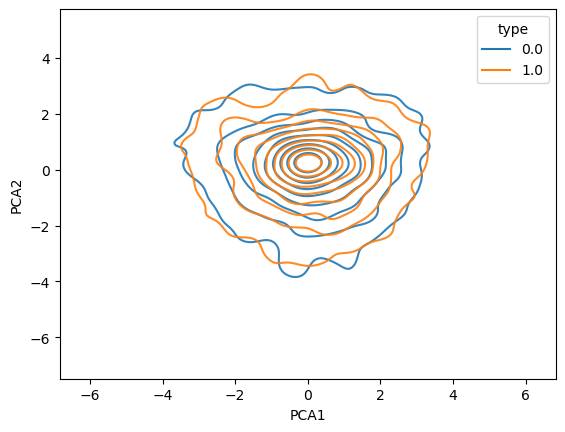

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
PCA_embedded = PCA(n_components=2)
trained_embedded = pd.DataFrame(embed_model.dv.vectors)
PCA_embedded.fit(trained_embedded)
test_embedded = PCA_embedded.transform(X_test_embed.to_list())
test_embedded = pd.DataFrame(test_embedded, columns=["PCA1", "PCA2"])
test_embedded["type"] = y_test

sns.kdeplot(data=test_embedded, x="PCA1", y="PCA2", hue="type", alpha=0.9)



In [ ]:
#building SVM - jeg tror dog graident /random forest er bedre
from sklearn.svm import LinearSVC

X_train_embed = pd.DataFrame(embed_model.dv.vectors)

svc = LinearSVC(max_iter=1000, random_state=42)
svc.fit(X_train_embed, y_train)
y_pred_svc = svc.predict(X_test_embed)
print(f"F1 Score: {f1_score(y_test, y_pred_svc):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc):.4f}")

: 

: 